# Data exploration
This notebook explores the information about Polish Parliment deputies using various visualizations.

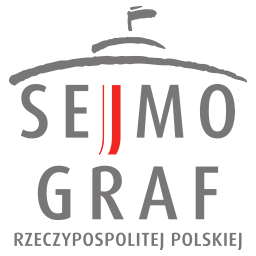


# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [2]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/SEJMograf /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/SEJMograf': File exists
/content/gdrive/My Drive/Colab Notebooks/SEJMograf


## Libraries & functions
Let's now install missing libraries and import the necessary libraries and functions we're gonna use in this notebook.

- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `plotly` - visualization

In [4]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load data

In [5]:
df = pd.read_csv('df_clean.csv', index_col=0)
df.head()

,first_name,middle_name,last_name,gender,profile_url,picture,election_date,election_list,election_constituency,election_votes,oath_date,sejm_prl_term_IX,sejm_prl_term_X,sejm_term_I,sejm_term_II,sejm_term_III,sejm_term_IV,sejm_term_V,sejm_term_VI,sejm_term_VII,sejm_term_VIII,senat_term_IX,senat_term_X,senat_term_I,senat_term_II,senat_term_III,senat_term_IV,senat_term_V,senat_term_VI,senat_term_VII,senat_term_VIII,sejm_term_IX,club,birth_date,birth_place,education,school,title,graduation_year,occupation,...,coworker_33,coworker_33_function,coworker_33_info,coworker_34,coworker_34_function,coworker_34_info,coworker_35,coworker_35_function,coworker_35_info,coworker_36,coworker_36_function,coworker_36_info,coworker_37,coworker_37_function,coworker_37_info,coworker_38,coworker_38_function,coworker_38_info,asset_declarations,declaration_01,declaration_01_info,declaration_02,declaration_02_info,benefit_registers,benefit_register_01,benefit_register_01_info,benefit_register_02,benefit_register_02_info,benefit_register_03,benefit_register_03_info,benefit_register_04,benefit_register_04_info,benefit_register_05,benefit_register_05_info,benefit_register_06,benefit_register_06_info,benefit_register_07,benefit_register_07_info,benefit_register_08,benefit_register_08_info
0,Andrzej,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8A510...,2019-10-13,Prawo i Sprawiedliwość,Kraków,29686,2019-11-12,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Prawo i Sprawiedliwość,1959-01-04,Krzeszowice,wyższe,Społeczna Akademia Nauk w Łodzi,licencjat,2014.0,poseł,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/A324231DA1...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/549650FA05...,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Rafał,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8ACA6...,2019-10-13,Sojusz Lewicy Demokratycznej,Katowice,12148,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,"Koalicyjny Klub Parlamentarny Lewicy (Razem, S...",1974-05-30,Dąbrowa Górnicza,wyższe,Politechnika Śląska,NaN,1999.0,samorządowiec,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/DB5AF9B44E...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FAE4951BE...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/EF53E6700...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Piotr,NaN,Adamowicz,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/3CA57...,2019-10-13,Koalicja Obywatelska,Gdańsk,41795,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Koalicja Obywatelska - Plat...,1961-06-26,Elbląg,średnie ogólne,VI LO Gdańsk,NaN,1980.0,dziennikarz/publicysta,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FF94DFF3A...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/2F249C8E3E...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/E7FACBAC8...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Romuald,NaN,Ajchler,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/5E88F...,2019-10-13,Sojusz Lewicy Demokratycznej,Piła,14438,2019-11-12,False,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,

# Explore personal data

## First name

In [6]:
layout = go.Layout(
                   title=go.layout.Title(text='Most frequent first names'),
                   xaxis=go.layout.XAxis(title='Name'),
                   yaxis=go.layout.YAxis(title='Number of occurances')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df['first_name'].value_counts().index[:10],
                       y=df['first_name'].value_counts().values[:10]
                      ),
                layout=layout    
               )
fig.show()

## Last name

In [7]:
layout = go.Layout(
                   title=go.layout.Title(text='Most frequent last names'),
                   xaxis=go.layout.XAxis(title='Last name'),
                   yaxis=go.layout.YAxis(title='Number of occurances')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df['last_name'].value_counts().index[:10],
                       y=df['last_name'].value_counts().values[:10]
                      ),
                layout=layout    
               )
fig.show()

## Gender

In [8]:
df['election_list'].unique()

array(['Prawo i Sprawiedliwość', 'Sojusz Lewicy Demokratycznej',
       'Koalicja Obywatelska', 'Polskie Stronnictwo Ludowe',
       'Konfederacja Wolność i Niepodległość', 'Mniejszość Niemiecka'],
      dtype=object)

In [9]:
layout = go.Layout(
                   title=go.layout.Title(text='Most frequent names'),
                   xaxis=go.layout.XAxis(title='Last name'),
                   yaxis=go.layout.YAxis(title='Number of occurances')
                  )
list_of_parties = df['election_list'].unique()

def barGender(gender):
  df_cropped = df[df['gender'] == gender]
  if gender == 'm':
    name = 'man'
  else:
    name = 'woman'
  x = df_cropped['election_list'].value_counts().index
  y = df_cropped['election_list'].value_counts().values
  bar = go.Bar(
      name = name,
      x = x,
      y = y,
      text = y,
      textposition = 'inside',

  )
  return bar

layout = go.Layout(
                   title=go.layout.Title(text='Gender distribution in political parties'),
                   xaxis=go.layout.XAxis(title='Name of the party'),
                   yaxis=go.layout.YAxis(title='Number of representatives'),
                   barmode = 'stack'
                  )

fig = go.Figure(
    data=[barGender(gender) for gender in df['gender'].unique()],
    layout = layout
    )

fig.show()

# Explore political data

## Election list

In [10]:
labels = df['election_list'].value_counts().index
values = df['election_list'].value_counts().values

layout = go.Layout(
                   title=go.layout.Title(text='Number of representatives')
                  )

fig = go.Figure(                
                go.Pie(
                       labels = labels,
                       values = values,
                       text = labels
                      ),
                layout=layout    
               )
fig.show()

## Election constituency

In [11]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='FindLatLon')

location_coordinates = {
    city:(
        geolocator.geocode(city).latitude,
        geolocator.geocode(city).longitude
        ) for city in df['election_constituency'].unique()
    }

In [12]:
def findLatLon(name, dictionary):
  # solve errors
  if name == 'Sowieda':
    name = 'As-Suwajda'
  elif name == 'Siedliszczo':
    name = 'Siedliszcze'
  elif name == 'Kocierz Rydzwałdzki':
    name = 'Kocierz Rychwałdzki'
  elif name == 'Aalbore':
    name = 'Aalborg'
  elif name == 'Plimkaim':
    name = 'Plinkajmy'
    
  lat = dictionary[name][0]
  lon = dictionary[name][1]
  return lat, lon

In [13]:
def countPlace(name, column):
  number = len(df[df[column] == name])
  return number

In [14]:
locations = df['election_constituency']
lat = df['election_constituency'].apply(lambda x: findLatLon(x, location_coordinates)[0])
lon = df['election_constituency'].apply(lambda x: findLatLon(x, location_coordinates)[1])
sizes = df['election_constituency'].apply(lambda x: countPlace(x, 'election_constituency'))

mapbox_access_token = open('.mapbox_token').read()


layout = go.Layout(
                   title = go.layout.Title(text='Constituencies'),
                   mapbox=dict(
                       accesstoken = mapbox_access_token,
                       bearing = 0,
                       center = go.layout.mapbox.Center(
                           lat=52.1,
                           lon=19.3
                           ),
                       zoom = 4.5,
                       style = 'dark'
                       ),
                   width = 600,
                   height = 600
)

fig = go.Figure(                
                go.Scattermapbox(
                    lat = lat,
                    lon = lon,
                    mode = 'text+markers',
                    marker = go.scattermapbox.Marker(
                        size=sizes,
                        color='orange',
                        opacity=sizes/np.linalg.norm(sizes),
                        autocolorscale=True,
                        colorbar=None,
                        colorscale='viridis',
                        sizemode='diameter'                    
                        ),                  
                    text = locations,
                    textfont = go.scattermapbox.Textfont(
                        color = 'white',
                        size = 10),
                    textposition = 'bottom center'
                ),
                layout=layout    
               )
fig.show()

In [15]:
def extractCounty(name):
  address = geolocator.geocode(name).address.split(', ')
  for a in address:
    if a.startswith('województwo'):
      county = a
  return county

counties = {
    const:extractCounty(const) for const in df['election_constituency'].unique()
    }

df['election_constituency_county'] = df['election_constituency'].apply(lambda x: counties[x])

In [16]:
layout = go.Layout(
                   title=go.layout.Title(text='Geographical distribution of deputies'),
                   xaxis=go.layout.XAxis(title='County'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df['election_constituency_county'].value_counts().index,
                       y=df['election_constituency_county'].value_counts().values
                      ),
                layout=layout    
               )
fig.show()

In [17]:
locations = df['election_constituency_county']

location_coordinates = {
    city:(
        geolocator.geocode(city).latitude,
        geolocator.geocode(city).longitude
        ) for city in df['election_constituency_county'].unique()
    }

lat = df['election_constituency_county'].apply(lambda x: findLatLon(x, location_coordinates)[0])
lon = df['election_constituency_county'].apply(lambda x: findLatLon(x, location_coordinates)[1])
sizes = df['election_constituency_county'].apply(lambda x: countPlace(x, 'election_constituency_county'))

mapbox_access_token = open('.mapbox_token').read()


layout = go.Layout(
                   title = go.layout.Title(text='Constituencies'),
                   mapbox=dict(
                       accesstoken = mapbox_access_token,
                       bearing = 0,
                       center = go.layout.mapbox.Center(
                           lat=52.1,
                           lon=19.3
                           ),
                       zoom = 4.5,
                       style = 'dark'
                       ),
                   width = 600,
                   height = 600
)

fig = go.Figure(                
                go.Scattermapbox(
                    lat = lat,
                    lon = lon,
                    mode = 'text+markers',
                    marker = go.scattermapbox.Marker(
                        size=sizes,
                        color='orange',
                        opacity=sizes/np.linalg.norm(sizes),
                        autocolorscale=True,
                        colorbar=None,
                        colorscale='viridis',
                        sizemode='diameter'                    
                        ),                  
                    text = locations,
                    textfont = go.scattermapbox.Textfont(
                        color = 'white',
                        size = 10),
                    textposition = 'bottom center'
                ),
                layout=layout    
               )
fig.show()

## Elecition votes

In [18]:
df_tmp = df.groupby('election_list').sum()['election_votes']
df_tmp

layout = go.Layout(
                   title=go.layout.Title(text='Cumulative number of votes'),
                   xaxis=go.layout.XAxis(title='Party'),
                   yaxis=go.layout.YAxis(title='Number of votes')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df_tmp.index,
                       y=df_tmp.values,
                       text=(df_tmp.values/df_tmp.sum())*100, # calculate percentage
                       texttemplate='%{text:.2f}%', # format text output
                       textposition='inside' #text position
                      ),
                layout=layout    
               )
fig.show()

## Individual votes count

In [19]:
layout = go.Layout(
    title = go.layout.Title(text='Election votes'),
    xaxis=dict(
        title='Number of votes',
        # gridcolor='white',
        type='log',
        # gridwidth=2,
        ),
    yaxis=dict(
        title='Party name',
        # gridcolor='white',
        # gridwidth=2,
        )
)

fig = go.Figure(
    data = [
            go.Scatter(
                x=df['election_votes'],
                y=df['election_list'],
                mode='markers',
                text=df['first_name']+' '+df['last_name']
                )
            ],
    layout=layout 
            )

fig.show()

## Votes statistical representation


In [40]:
layout = go.Layout(
    title = go.layout.Title(text='Votes statistical representation'),
    xaxis=dict(
        title='Number of votes',
        type='log'
    )
)

fig = go.Figure(
    data = [
            go.Box(
                x=df[df['election_list']==l]['election_votes'],
                name=l,
                hovertext=l,
                # mode='markers'
            ) for l in df['election_list'].unique()
            ],
    layout=layout 
            )

fig.show()

## Service history

### Sejm

In [21]:
sejm_terms = [
    'sejm_prl_term_IX',
    'sejm_prl_term_X',
    'sejm_term_I',
    'sejm_term_II',
    'sejm_term_III',
    'sejm_term_IV',
    'sejm_term_V',
    'sejm_term_VI',
    'sejm_term_VII',
    'sejm_term_VIII',
    'sejm_term_IX'
]          

df_tmp = pd.Series(
    data=(df[df[term]==True].shape[0] for term in sejm_terms),
    index=sejm_terms
    )          	

data = [
        go.Bar(
            x=df_tmp.index,
            y=df_tmp.values,
            # xaxis=dict(
            #     title='Number of votes'
            #     )
            )
        ]

layout = go.Layout(
                   title=go.layout.Title(text='Service history'),
                   xaxis=go.layout.XAxis(title='Term name'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )
fig = go.Figure(                
                data=data,
                layout=layout    
               )
fig.show()

### Senat

In [22]:
senat_terms = [
    'senat_term_I',
    'senat_term_II',
    'senat_term_III',
    'senat_term_IV',
    'senat_term_V',
    'senat_term_VI',
    'senat_term_VII',
    'senat_term_VIII',
    'senat_term_IX',
    'senat_term_X',   
]   

df_tmp = pd.Series(
    data=(df[df[term]==True].shape[0] for term in senat_terms),
    index=senat_terms
    )          	

data = [
        go.Bar(
            x=df_tmp.index,
            y=df_tmp.values,
            # xaxis=dict(
            #     title='Number of votes'
            #     )
            )
        ]

layout = go.Layout(
                   title=go.layout.Title(text='Service history'),
                   xaxis=go.layout.XAxis(title='Term name'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )
fig = go.Figure(                
                data=data,
                layout=layout    
               )
fig.show()

In [23]:
# senat_terms = [
#     'senat_term_I',
#     'senat_term_II',
#     'senat_term_III',
#     'senat_term_IV',
#     'senat_term_V',
#     'senat_term_VI',
#     'senat_term_VII',
#     'senat_term_VIII',
#     'senat_term_IX',
#     'senat_term_X',   
# ]   


# def plotServiceHistory(terms):  
  
  
#   df_tmp = df[df.loc[:, 'election_list'] == 'Prawo i Sprawiedliwość']


#   data = [
#           go.Scatter(
#               # x=df[df.loc[:, 'election_list'] == party].index,
#               x=df
#               y=df[df.loc[:, 'election_list'] == party].values,
#               mode='lines',
#               name=party
#               # xaxis=dict(
#               #     title='Number of votes'
#               #     )
#               )
#           for party in df['election_list'].unique()]

#   layout = go.Layout(
#                     title=go.layout.Title(text='Service history'),
#                     xaxis=go.layout.XAxis(title='Term name'),
#                     yaxis=go.layout.YAxis(title='Number of representatives')
#                     )
#   fig = go.Figure(                
#                   data=data,
#                   layout=layout    
#                 )
#   fig.show()


# plotServiceHistory(senat_terms)


# # fig = go.Figure()
# # fig.add_trace(
# #     go.Scatter(
# #         x=df_tmp.index,
# #         y=df_tmp.values,
# #         mode='lines',
# #         name='lines'
# #         )
# #     )




# # fig.add_trace(go.Scatter(x=random_x, y=random_y1,
# #                     mode='lines+markers',
# #                     name='lines+markers'))
# # fig.add_trace(go.Scatter(x=random_x, y=random_y2,
# #                     mode='markers', name='markers'))

# # fig.show()

In [24]:
term_dict = {}

for party in df['election_list'].unique():
  df_tmp = df[df.loc[:, 'election_list'] == party]
  term_list = pd.Series(
      data=(df_tmp[df_tmp[term]==True].shape[0] for term in sejm_terms),
      index=sejm_terms
      )  
  term_dict[party] = term_list

df_terms_sejm = pd.DataFrame(term_dict)
df_terms_sejm

,Prawo i Sprawiedliwość,Sojusz Lewicy Demokratycznej,Koalicja Obywatelska,Polskie Stronnictwo Ludowe,Konfederacja Wolność i Niepodległość,Mniejszość Niemiecka
sejm_prl_term_IX,0,0,1,0,0,0
sejm_prl_term_X,0,0,1,1,0,0
sejm_term_I,3,0,3,0,1,0
sejm_term_II,0,4,2,3,0,0
sejm_term_III,9,4,5,3,0,0
sejm_term_IV,14,5,11,5,0,0
sejm_term_V,55,4,33,7,1,1
sejm_term_VI,69,5,50,7,0,1
sejm_term_VII,79,7,66,8,0,1
sejm_term_VIII,172,1,90,18,2,1


In [25]:
term_dict = {}

for party in df['election_list'].unique():
  df_tmp = df[df.loc[:, 'election_list'] == party]
  term_list = pd.Series(
      data=(df_tmp[df_tmp[term]==True].shape[0] for term in senat_terms),
      index=senat_terms
      )  
  term_dict[party] = term_list

df_terms_senat = pd.DataFrame(term_dict)
df_terms_senat

,Prawo i Sprawiedliwość,Sojusz Lewicy Demokratycznej,Koalicja Obywatelska,Polskie Stronnictwo Ludowe,Konfederacja Wolność i Niepodległość,Mniejszość Niemiecka
senat_term_I,1,0,0,0,0,0
senat_term_II,0,0,0,0,0,0
senat_term_III,0,0,0,0,0,0
senat_term_IV,2,0,0,0,0,0
senat_term_V,0,0,1,0,0,0
senat_term_VI,2,0,4,0,0,0
senat_term_VII,2,0,3,0,0,0
senat_term_VIII,2,0,2,0,0,0
senat_term_IX,1,0,3,0,0,0
senat_term_X,0,0,0,0,0,0


In [26]:
data = [
        go.Scatter(
            x=df_terms_sejm[party].index,
            y=df_terms_sejm[party].values,
            name=party,
            mode='lines+markers'
            ) for party in df['election_list'].unique()
        ]


layout = go.Layout(
                   title=go.layout.Title(text='Service history'),
                   xaxis=go.layout.XAxis(title='Term name'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )
fig = go.Figure(                
                data=data,
                layout=layout    
               )
fig.show()

In [27]:
data = [
        go.Scatter(
            x=df_terms_senat[party].index,
            y=df_terms_senat[party].values,
            mode='lines+markers',
            name=party
            ) for party in df['election_list'].unique()
        ]


layout = go.Layout(
                   title=go.layout.Title(text='Service history'),
                   xaxis=go.layout.XAxis(title='Term name'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )
fig = go.Figure(                
                data=data,
                layout=layout    
               )
fig.show()

## Club transfers

In [28]:
df['club'].unique()

array(['Klub Parlamentarny Prawo i Sprawiedliwość',
       'Koalicyjny Klub Parlamentarny Lewicy (Razem, Sojusz Lewicy Demokratycznej, Wiosna Roberta Biedronia)',
       'Klub Parlamentarny Koalicja Obywatelska - Platforma Obywatelska, Nowoczesna, Inicjatywa Polska, Zieloni',
       'Klub Parlamentarny Koalicja Polska - PSL, UED, Konserwatyści',
       'Koło Poselskie Konfederacja', 'Poseł niezrzeszony'], dtype=object)

# Explore CV data

## Birth date

In [29]:
import datetime
from dateutil.relativedelta import relativedelta

def calculateAge(date):
  today = datetime.date.today()
  birthdate = datetime.datetime.strptime(date, '%Y-%m-%d').date()

  age = relativedelta(today, birthdate)
  age = age.years



  return age

df['age'] = df['birth_date'].apply(lambda x: calculateAge(x))
df.head()


,first_name,middle_name,last_name,gender,profile_url,picture,election_date,election_list,election_constituency,election_votes,oath_date,sejm_prl_term_IX,sejm_prl_term_X,sejm_term_I,sejm_term_II,sejm_term_III,sejm_term_IV,sejm_term_V,sejm_term_VI,sejm_term_VII,sejm_term_VIII,senat_term_IX,senat_term_X,senat_term_I,senat_term_II,senat_term_III,senat_term_IV,senat_term_V,senat_term_VI,senat_term_VII,senat_term_VIII,sejm_term_IX,club,birth_date,birth_place,education,school,title,graduation_year,occupation,...,coworker_33_info,coworker_34,coworker_34_function,coworker_34_info,coworker_35,coworker_35_function,coworker_35_info,coworker_36,coworker_36_function,coworker_36_info,coworker_37,coworker_37_function,coworker_37_info,coworker_38,coworker_38_function,coworker_38_info,asset_declarations,declaration_01,declaration_01_info,declaration_02,declaration_02_info,benefit_registers,benefit_register_01,benefit_register_01_info,benefit_register_02,benefit_register_02_info,benefit_register_03,benefit_register_03_info,benefit_register_04,benefit_register_04_info,benefit_register_05,benefit_register_05_info,benefit_register_06,benefit_register_06_info,benefit_register_07,benefit_register_07_info,benefit_register_08,benefit_register_08_info,election_constituency_county,age
0,Andrzej,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8A510...,2019-10-13,Prawo i Sprawiedliwość,Kraków,29686,2019-11-12,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Prawo i Sprawiedliwość,1959-01-04,Krzeszowice,wyższe,Społeczna Akademia Nauk w Łodzi,licencjat,2014.0,poseł,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/A324231DA1...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/549650FA05...,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,województwo małopolskie,62
1,Rafał,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8ACA6...,2019-10-13,Sojusz Lewicy Demokratycznej,Katowice,12148,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,"Koalicyjny Klub Parlamentarny Lewicy (Razem, S...",1974-05-30,Dąbrowa Górnicza,wyższe,Politechnika Śląska,NaN,1999.0,samorządowiec,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/DB5AF9B44E...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FAE4951BE...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/EF53E6700...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,województwo śląskie,46
2,Piotr,NaN,Adamowicz,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/3CA57...,2019-10-13,Koalicja Obywatelska,Gdańsk,41795,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Koalicja Obywatelska - Plat...,1961-06-26,Elbląg,średnie ogólne,VI LO Gdańsk,NaN,1980.0,dziennikarz/publicysta,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FF94DFF3A...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/2F249C8E3E...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/E7FACBAC8...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,województwo pomorskie,59
3,Romuald,NaN,Ajchler,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/5E88F...,2019-10-13,Sojusz Lewicy Demokratycznej,Piła,14438,2019-11-12,False,False,False,True,True,True,False,True,True,Fal

In [30]:
layout = go.Layout(
    title = go.layout.Title(text='Age of the representatives'),
    height=700,
    xaxis=dict(
        title='Age',
        # type='log'
    )
)

fig = go.Figure(
    data = [
            go.Box(
                x=df[df['election_list']==l]['age'],
                name=l,
                hovertext=df[df['election_list']==l]['first_name']+' '+df[df['election_list']==l]['last_name'],
                boxpoints='all',
                jitter=0.5,
                pointpos=-2,

            ) for l in df['election_list'].unique()
            ],
    layout=layout 
            )

fig.show()

## Birth place

In [31]:
#initiate coordinates container
birthplace_coordinates = {}

# iterate through unique cities
for city in df['birth_place'].unique():
  # solve errors
  if city == 'Sowieda':
    city = 'As-Suwajda'
  elif city == 'Siedliszczo':
    city = 'Siedliszcze'
  elif city == 'Kocierz Rydzwałdzki':
    city = 'Kocierz Rychwałdzki'
  elif city == 'Aalbore':
    city = 'Aalborg'
  elif city == 'Plimkaim':
    city = 'Plinkajmy'

  # append latitude & longitude to the dictionary
  birthplace_coordinates[city] = (
      geolocator.geocode(city).latitude,
      geolocator.geocode(city).longitude
      )

In [32]:
locations = df['birth_place']
lat = df['birth_place'].apply(lambda x: findLatLon(x, birthplace_coordinates)[0])
lon = df['birth_place'].apply(lambda x: findLatLon(x, birthplace_coordinates)[1])
sizes = df['birth_place'].apply(lambda x: countPlace(x, 'birth_place'))

mapbox_access_token = open('.mapbox_token').read()


layout = go.Layout(
                   title = go.layout.Title(text='Birth places'),
                   mapbox=dict(
                       accesstoken = mapbox_access_token,
                       bearing = 0,
                       center = go.layout.mapbox.Center(
                           lat=52.1,
                           lon=19.3
                           ),
                       zoom = 4.5,
                       style = 'dark'
                       ),
                   width = 600,
                   height = 600
)

fig = go.Figure(                
                go.Scattermapbox(
                    lat = lat,
                    lon = lon,
                    mode = 'text+markers',
                    marker = go.scattermapbox.Marker(
                        size=sizes,
                        color='orange',
                        opacity=sizes/np.linalg.norm(sizes),
                        autocolorscale=True,
                        colorbar=None,
                        colorscale='viridis',
                        sizemode='diameter'                    
                        ),                  
                    text = df['birth_place'],
                    # hovertext = df['first_name']+' '+df['last_name'],
                    textfont = go.scattermapbox.Textfont(
                        color = 'white',
                        size = 10),
                    textposition = 'bottom center'
                ),
                layout=layout    
               )
fig.show()

## Education

In [33]:


def plotEducationPie(party, row, col):
  fig.add_trace(
    go.Pie(
        labels=df['education'].unique(),
        values=[
                df[
                   (df['election_list'] == party) &
                   (df['education'] == edu)
                   ].shape[0] for edu in df['education'].unique()],
        name=party
        ), row, col)

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(
    rows=2,
    cols=3,
    specs=[
           [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}],
           [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]
           ]
    )

plotEducationPie('Prawo i Sprawiedliwość', 1, 1)
plotEducationPie('Sojusz Lewicy Demokratycznej', 1, 2)
plotEducationPie('Koalicja Obywatelska', 1, 3)
plotEducationPie('Polskie Stronnictwo Ludowe', 2, 1)
plotEducationPie('Konfederacja Wolność i Niepodległość', 2, 2)
plotEducationPie('Mniejszość Niemiecka', 2, 3)

# Use `hole` to create a donut-like pie chart
fig.update_traces(
    hoverinfo='label+value',
    textinfo='percent',
    hole=.4)

fig.update_layout(
    title_text='Education',
    width = 1200,
    height = 900,
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='PiS', x=0.12, y=0.81, font_size=20, showarrow=False),
                 dict(text='SLD', x=0.5, y=0.81, font_size=20, showarrow=False),
                 dict(text='KO', x=0.88, y=0.81, font_size=20, showarrow=False),
                 dict(text='PSL', x=0.12, y=0.19, font_size=20, showarrow=False),
                 dict(text='K', x=0.5, y=0.19, font_size=20, showarrow=False),
                 dict(text='MN', x=0.88, y=0.19, font_size=20, showarrow=False)])
fig.show()

## School

In [34]:
layout = go.Layout(
                   title=go.layout.Title(text='Most popular schools'),
                   xaxis=go.layout.XAxis(title='School name'),
                   yaxis=go.layout.YAxis(title='Number of graduates')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df['school'].value_counts().index[:15],
                       y=df['school'].value_counts().values[:15]
                      ),
                layout=layout    
               )
fig.show()

## Title

In [41]:
df['title'].fillna('brak', inplace=True)

layout = go.Layout(
                   title=go.layout.Title(text='Scientific titles'),
                   xaxis=go.layout.XAxis(title='Title name'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df['title'].value_counts().index,
                       y=df['title'].value_counts().values
                      ),
                layout=layout    
               )
fig.show()

## Graduation year

In [55]:
df.loc[449, 'graduation_year'] = 1975

layout = go.Layout(
    title = go.layout.Title(text='Graduation year'),
    xaxis=dict(
        title='Year',
        # gridcolor='white',
        # type='log',
        # gridwidth=2,
        ),
    yaxis=dict(
        title='Party name',
        # gridcolor='white',
        # gridwidth=2,
        )
)

fig = go.Figure(
    data = [
            go.Scatter(
                x=df['graduation_year'],
                y=df['election_list'],
                mode='markers',
                text=df['first_name']+' '+df['last_name']
                )
            ],
    layout=layout 
            )

fig.show()

## Occupation

In [83]:
df['title'].fillna('brak', inplace=True)

layout = go.Layout(
                   title=go.layout.Title(text='Occupation'),
                   xaxis=go.layout.XAxis(title='Name'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )

# percentage = ['%.2f' % (x/4.59) for x in df['occupation'].value_counts().values[:15]]
percentage = [f'{int(x/4.59)}%' for x in df['occupation'].value_counts().values[:15]]

fig = go.Figure(                
                go.Bar(
                       x=df['occupation'].value_counts().index[:10],
                       y=df['occupation'].value_counts().values[:10],
                       text=percentage,
                       textposition='auto',
                      ),
                layout=layout    
               )
fig.show()

# Activity data

## Helper function

In [111]:
def displayActivity(activity):

  data = [
          go.Box(
              x = df[df['election_list'] == l][activity],
              name=l,
              hovertext=df[df['election_list']==l]['first_name']+' '+df[df['election_list']==l]['last_name'],
              boxpoints='all',
              jitter=0.5,
              pointpos=-2
              ) for l in df['election_list'].unique()
              ]

  layout = go.Layout(
      title = go.layout.Title(text=activity),
      height=700,
      xaxis=dict(
          title=activity,
      )
  )

  fig = go.Figure(
      data = data,
      layout=layout 
              )

  fig.show()

## Speeches

In [112]:
displayActivity('speeches_number')

## Interpellations

In [113]:
displayActivity('interpellations_pursued_number')

In [114]:
displayActivity('interpellations_dismissed_number')

## Inquiries

In [115]:
displayActivity('inquiries_pursued_number')

In [116]:
displayActivity('inquiries_dismissed_number')

## Statements

In [117]:
displayActivity('statements_number')

## Current questions

In [118]:
displayActivity('current_questions_number')

## Total activity

In [125]:
activities = [
              'speeches_number',
              'interpellations_pursued_number',
              'interpellations_dismissed_number',
              'inquiries_pursued_number',
              'inquiries_dismissed_number',
              'statements_number',
              'current_questions_number'
]

def sumActivities(x):
  acts = [x[a] for a in activities]
  act_sum = sum(acts)
  return act_sum

df['total_activity'] = df.apply(lambda x: sumActivities(x), axis=1)

displayActivity('total_activity')

## Voting frequency

In [128]:
displayActivity('voting_frequency')

# Memberships

## Helper function

In [169]:
def displayMembership(membership, top):
  layout = go.Layout(
                    # title=go.layout.Title(text=membership),
                    xaxis=go.layout.XAxis(title='Name'),
                    yaxis=go.layout.YAxis(title='Number of members')
                    )
  fig = go.Figure(                
                  go.Bar(
                        x=membership.index[:top],
                        y=membership.values[:top]
                        ),
                  layout=layout    
                )
  fig.show()

## Committees

In [164]:
displayActivity('committees')

In [171]:
committees = {
 'committee_01': 'Komisja  Łączności z Polakami za Granicą',
 'committee_02': 'Komisja  Kultury i Środków Przekazu',
 'committee_03': 'Komisja  do Spraw Kontroli Państwowej',
 'committee_04': 'Komisja  Ustawodawcza',
 'committee_05': 'Komisja  do Spraw Petycji',
 'committee_06': 'Komisja  Rolnictwa i Rozwoju Wsi',
 'committee_07': 'Komisja  Infrastruktury',
 'committee_08': 'Komisja  Spraw Zagranicznych',
 'committee_09': 'Komisja  Sprawiedliwości i Praw Człowieka',
 'committee_10': 'Komisja  Zdrowia',
 'committee_11': 'Komisja  do Spraw Służb Specjalnych',
 'committee_12': 'Komisja  do Spraw Energii, Klimatu i Aktywów Państwowych',
 'committee_13': 'Komisja  Odpowiedzialności Konstytucyjnej',
 'committee_14': 'Komisja  Edukacji, Nauki i Młodzieży',
 'committee_15': 'Komisja  Cyfryzacji, Innowacyjności i Nowoczesnych Technologii',
 'committee_16': 'Komisja  Polityki Senioralnej',
 'committee_17': 'Komisja  Ochrony Środowiska, Zasobów Naturalnych i Leśnictwa',
 'committee_18': 'Komisja  Administracji i Spraw Wewnętrznych',
 'committee_19': 'Komisja  Samorządu Terytorialnego i Polityki Regionalnej',
 'committee_20': 'Komisja  Mniejszości Narodowych i Etnicznych',
 'committee_21': 'Komisja  Gospodarki i Rozwoju',
 'committee_22': 'Komisja  Polityki Społecznej i Rodziny',
 'committee_23': 'Komisja  Obrony Narodowej',
 'committee_24': 'Komisja  Finansów Publicznych',
 'committee_25': 'Komisja  Etyki Poselskiej',
 'committee_26': 'Komisja  Regulaminowa, Spraw Poselskich i Immunitetowych',
 'committee_27': 'Komisja  do Spraw Unii Europejskiej',
 'committee_28': 'Komisja  Kultury Fizycznej, Sportu i Turystyki',
 'committee_29': 'Komisja  Gospodarki Morskiej i Żeglugi Śródlądowej'
 }

committees_sum = pd.Series(
    {name:df[key].sum() for key, name in committees.items()}
).sort_values(ascending=False)


displayMembership(committees_sum, 15)

## Delegations


In [131]:
displayActivity('delegations')

In [172]:
delegations = {
 'delegation_01': 'Polsko-Cypryjska Grupa Parlamentarna',
 'delegation_02': 'Polsko-Bułgarska Grupa Parlamentarna',
 'delegation_03': 'Delegacja Sejmu i Senatu RP do Wymiaru Parlamentarnego Inicjatywy Środkowoeuropejskiej',
 'delegation_04': 'Polsko-Palestyńska Grupa Parlamentarna',
 'delegation_05': 'Delegacja Sejmu i Senatu RP do Zgromadzenia Parlamentarnego NATO',
 'delegation_06': 'Polsko-Fińska Grupa Parlamentarna',
 'delegation_07': 'Delegacja do Zgromadzenia Parlamentarnego Rzeczypospolitej Polskiej i Gruzji',
 'delegation_08': 'Zespół Parlamentarny Polska-USA',
 'delegation_09': 'Polsko-Duńska Grupa Parlamentarna',
 'delegation_10': 'Polsko-Tajwański Zespół Parlamentarny',
 'delegation_11': 'Delegacja Sejmu i Senatu RP do Zgromadzenia Parlamentarnego OBWE',
 'delegation_12': 'Polsko-Francuska Grupa Parlamentarna',
 'delegation_13': 'Polsko-Austriacka Grupa Parlamentarna',
 'delegation_14': 'Polsko-Słowacka Grupa Parlamentarna',
 'delegation_15': 'Polsko-Szwedzka Grupa Parlamentarna',
 'delegation_16': 'Polsko-Brazylijska Grupa Parlamentarna',
 'delegation_17': 'Polsko-Białoruska Grupa Parlamentarna',
 'delegation_18': 'Polsko-Chińska Grupa Parlamentarna',
 'delegation_19': 'Polsko-Bałkańska Grupa Parlamentarna',
 'delegation_20': 'Grupa Parlamentarna Polska-Macedonia Północna',
 'delegation_21': 'Polsko-Niemiecka Grupa Parlamentarna',
 'delegation_22': 'Grupa Parlamentarna Polska-Republika Korei',
 'delegation_23': 'Grupa Parlamentarna Polska-Zjednoczone Emiraty Arabskie',
 'delegation_24': 'Polsko-Islandzka Grupa Parlamentarna',
 'delegation_25': 'Delegacja Sejmu i Senatu do Zgromadzenia Parlamentarnego Rady Europy',
 'delegation_26': 'Polsko-Włoska Grupa Parlamentarna',
 'delegation_27': 'Polsko-Czeska Grupa Parlamentarna',
 'delegation_28': 'Polsko-Saudyjska Grupa Parlamentarna',
 'delegation_29': 'Polska Sekcja Stowarzyszona Zgromadzenia Parlamentarnego Frankofonii',
 'delegation_30': 'Polsko-Izraelska Grupa Parlamentarna',
 'delegation_31': 'Delegacja Sejmu i Senatu RP do Zgromadzenia Parlamentarnego Sejmu i Senatu RP i Sejmu Republiki Litewskiej',
 'delegation_32': 'Delegacja Sejmu i Senatu RP na Konferencję Parlamentarną Morza Bałtyckiego',
 'delegation_33': 'Polsko-Zambijska Grupa Parlamentarna',
 'delegation_34': 'Polsko-Niderlandzka Grupa Parlamentarna',
 'delegation_35': 'Polsko-Chorwacka Grupa Parlamentarna',
 'delegation_36': 'Polsko-Hiszpańska Grupa Parlamentarna',
 'delegation_37': 'Polsko-Słoweńska Grupa Parlamentarna',
 'delegation_38': 'Delegacja Parlamentarna do Zgromadzenia Parlamentarnego RP i Ukrainy',
 'delegation_39': 'Polsko-Egipska Grupa Parlamentarna',
 'delegation_40': 'Polsko-Gruzińska Grupa Parlamentarna',
 'delegation_41': 'Polsko-Norweska Grupa Parlamentarna',
 'delegation_42': 'Polsko-Kirgistańska Grupa Parlamentarna',
 'delegation_43': 'Polsko-Luksemburska Grupa Parlamentarna',
 'delegation_44': 'Delegacja do Zgromadzenia Parlamentarnego Rzeczypospolitej Polskiej i Republiki Mołdawii',
 'delegation_45': 'Polsko-Grecka Grupa Parlamentarna',
 'delegation_46': 'Polsko-Brytyjska Grupa Parlamentarna',
 'delegation_47': 'Zarząd Polskiej Grupy Unii Międzyparlamentarnej',
 'delegation_48': 'Polsko-Peruwiańska Grupa Parlamentarna',
 'delegation_49': 'Polsko-Katarska Grupa Parlamentarna'
 }
 
delegations_sum = pd.Series(
    {name:df[key].sum() for key, name in delegations.items()}
).sort_values(ascending=False)


displayMembership(delegations_sum, 15)

## Groups

In [132]:
displayActivity('groups')

In [173]:
groups = {
 'group_01': 'Parlamentarny Zespół ds. Bogactw Naturalnych i Aktywów Narodowych',
 'group_02': 'Parlamentarny Zespół ds. Poczty Polskiej',
 'group_03': 'Parlamentarny Zespół ds. Ratownictwa Górskiego',
 'group_04': 'Parlamentarny Zespół ds. Rozwoju Pomorza Środkowego',
 'group_05': 'Parlamentarny Zespół na rzecz Rozwoju i Promocji Polskiego Handlu',
 'group_06': 'Parlamentarny Zespół ds. Chorób Neurologicznych',
 'group_07': 'Parlamentarny Zespół Miłośników Historii',
 'group_08': 'Parlamentarny Zespół ds. Centralnego Portu Komunikacyjnego',
 'group_09': 'Parlamentarny Zespół ds. Walki z Cenzurą na Uczelniach',
 'group_10': 'Parlamentarny Zespół ds. m. st. Warszawy',
 'group_100': 'Parlamentarny Zespół ds. Uzdrowisk',
 'group_101': 'Parlamentarny Zespół Antysmogowy',
 'group_102': 'Parlamentarny Zespół ds. Samorządności',
 'group_103': 'Parlamentarny Zespół ds. Autyzmu',
 'group_11': 'Parlamentarny Zespół do spraw Przyszłości Pracy',
 'group_12': 'Parlamentarny Zespół ds. Ochrony Morza Bałtyckiego',
 'group_13': 'Parlamentarny Zespół ds. Szpitali Powiatowych',
 'group_14': 'Opolski Zespół Parlamentarny',
 'group_15': 'Parlamentarny Zespół ds. Pielęgniarek, Położnych i Pracowników Opieki Zdrowotnej',
 'group_16': 'Parlamentarny Zespół ds. Chorób Rzadkich',
 'group_17': 'Parlamentarny Zespół ds. Ochrony Pojezierzy Wielkopolskich',
 'group_18': 'Parlamentarny Zespół na rzecz Wspierania Przedsiębiorczości i Patriotyzmu Ekonomicznego',
 'group_19': 'Parlamentarny Zespół ds. Bezpieczeństwa Szczepień Ochronnych Dzieci i Dorosłych',
 'group_20': 'Parlamentarny Zespół ds. Budowy Drogi S10',
 'group_21': 'Parlamentarny Zespół ds. Rozwoju i Wsparcia Przedsiębiorstw',
 'group_22': 'Parlamentarny Zespół ds. Analiz Strategicznego Rozwoju Państwa - Gwiaździste Niebo',
 'group_23': 'Parlamentarny Zespół ds. Podiatrii, Podologii i Kosmetologii',
 'group_24': 'Parlamentarny Zespół ds. Promocji Krwiodawstwa, Dawstwa Szpiku Kostnego oraz Transplantologii',
 'group_25': 'Parlamentarny Zespół ds. Elektromobilności',
 'group_26': 'Parlamentarny Zespół ds. Rozwiązywania Problemów Mieszkańców "Polski Powiatowo-Gminnej"',
 'group_27': 'Parlamentarny Zespół ds. Rozwiązywania Problemów Uzależnień',
 'group_28': 'Parlamentarny Zespół ds. Rozwoju i Przekształceń Regionu Bełchatowskiego',
 'group_29': 'Parlamentarny Zespół ds. Opieki nad Osobami Niesamodzielnymi',
 'group_30': 'Parlamentarny Zespół ds. Infrastruktury Transportowej na Dolnym Śląsku',
 'group_31': 'Parlamentarny Zespół ds. Lecznictwa Uzdrowiskowego i Mundurowej Służby Zdrowia',
 'group_32': 'Parlamentarny Zespół ds. Energetyki',
 'group_33': 'Parlamentarny Zespół ds. Trójmorza',
 'group_34': 'Parlamentarny Zespół na rzecz Katolickiej Nauki Społecznej',
 'group_35': 'Parlamentarny Zespół Członków i Sympatyków Ruchu Światło-Życie i Akcji Katolickiej',
 'group_36': 'Parlamentarny Zespół ds. Afryki',
 'group_37': 'Parlamentarny Zespół ds. Bezpieczeństwa Lekowego i Rynku Aptecznego w Polsce',
 'group_38': 'Parlamentarny Zespół ds. Gospodarki Zeroemisyjnej i Europejskiego Zielonego Ładu',
 'group_39': 'Parlamentarny Zespół Karpacki',
 'group_40': 'Parlamentarny Zespół ds. Piłki Siatkowej',
 'group_41': 'Parlamentarny Zespół ds. Energetyki Jądrowej',
 'group_42': 'Parlamentarny Zespół ds. Suwerenności Lekowej Polski',
 'group_43': 'Łódzki Zespół Parlamentarny',
 'group_44': 'Parlamentarny Zespół ds. Energii Odnawialnej',
 'group_45': 'Parlamentarny Zespół ds. Marihuany Medycznej',
 'group_46': 'Parlamentarny Zespół ds. Naprawy Rzeczypospolitej',
 'group_47': 'Parlamentarny Zespół ds. Nordic Walkingu',
 'group_48': 'Parlamentarny Zespół Przyjaciół Zwierząt',
 'group_49': 'Parlamentarny Zespół ds. Białorusi',
 'group_50': 'Parlamentarny Zespół ds. Rozwiązań Komunikacyjnych w Małopolsce, w szczególności Budowy Nowej Linii Kolejowej Podłęże - Szczyrzyc - Tymbark/Mszana Dolna oraz Modernizacji Istniejącej Linii Kolejowej nr 104 Chabówka - Nowy Sącz, a także Budowy Drogi Szybkiego Ruchu z Brzeska do Nowego Sącza i dalej do Granicy Państwa w Muszynce tzw. "Sądeczanki"',
 'group_51': 'Parlamentarny Zespół ds. Ekologii i Polskiego Zielarstwa',
 'group_52': 'Parlamentarny Zespół ds. Zdrowia Psychicznego Dzieci i Młodzieży',
 'group_53': 'Parlamentarny Zespół ds. Wędkarstwa',
 'group_54': 'Parlamentarny Zespół ds. Ochrony Zwierząt, Praw Właścicieli Zwierząt oraz Rozwoju Polskiego Rolnictwa',
 'group_55': 'Parlamentarny Zespół Sportowy',
 'group_56': 'Parlamentarny Zespół ds. Kaskadyzacji Dolnej Wisły',
 'group_57': 'Parlamentarny Zespół ds. Budowy Drogi Ekspresowej S16',
 'group_58': 'Parlamentarny Zespół ds. Województwa Śląskiego',
 'group_59': 'Parlamentarny Zespół ds. Edukacji Seksualnej',
 'group_60': 'Parlamentarny Zespół ds. Cyberbezpieczeństwa Dzieci',
 'group_61': 'Parlamentarny Zespół ds. Kultury i Środowisk Twórczych',
 'group_62': 'Parlamentarny Zespół ds. Budowy Kolei w ramach Siatki Połączeń z Centralnym Portem Komunikacyjnym Warszawa  - Ostrołęka - Łomża - Kolno - Pisz - Orzysz - Giżycko - tzw. Kolei Warszawsko - Mazurskiej przez Łomżę',
 'group_63': 'Lubelski Zespół Parlamentarny',
 'group_64': 'Parlamentarny Zespół ds. Wspierania Młodzieżowych Rad przy Jednostkach Samorządu Terytorialnego',
 'group_65': 'Parlamentarny Zespół ds. Przemysłu Drzewnego i Budownictwa Drewnianego',
 'group_66': 'Parlamentarny Zespół ds. Bezpieczeństwa Ruchu Drogowego',
 'group_67': 'Parlamentarny Zespół ds. Obrony Wolności Słowa',
 'group_68': 'Parlamentarny Zespół ds. Osób z Niepełnosprawnościami',
 'group_69': 'Parlamentarny Zespół ds. Środowiska, Energii i Klimatu',
 'group_70': 'Parlamentarny Zespół ds. Onkologii',
 'group_71': 'Dolnośląski Zespół Parlamentarny',
 'group_72': 'Parlamentarny Zespół ds. Praw Pacjentów',
 'group_73': 'Wielkopolski Zespół Parlamentarny',
 'group_74': 'Parlamentarny Zespół ds. Złoczewa',
 'group_75': 'Parlamentarny Zespół ds. Polskiej Branży Cukrowej',
 'group_76': 'Parlamentarny Zespół ds. Armenii',
 'group_77': 'Parlamentarny Zespół ds. Rozwoju Kół Gospodyń Wiejskich i Miejskich',
 'group_78': 'Parlamentarny Zespół Byłych Działaczy Ruchu Studenckiego "Ordynacka"',
 'group_79': 'Parlamentarny Zespół do spraw Równouprawnienia Społeczności LGBT+',
 'group_80': 'Parlamentarny Zespół ds. Przyszłości Unii Europejskiej',
 'group_81': 'Parlamentarny Zespół ds. Języka  Śląskiego i Kultury Śląskiej',
 'group_82': 'Parlamentarny Zespół ds. Dziedzictwa Świętego Jana Pawła II',
 'group_83': 'Parlamentarny Zespół ds. Obrony Praw Kierowców',
 'group_84': 'Parlamentarny Zespół do spraw Polityki Migracyjnej i Integracyjnej',
 'group_85': 'Karkonoski Zespół Parlamentarny',
 'group_86': 'Poselski Zespół ds. Nowego Zielonego Ładu',
 'group_87': 'Parlamentarny Zespół ds. Policji',
 'group_88': 'Parlamentarny Zespół Przyjaciół Królewskiego Miasta Sandomierza',
 'group_89': 'Parlamentarna Grupa Kobiet',
 'group_90': 'Parlamentarny Zespół ds. Dworca PKP Poznań Główny oraz Poznańskiego Węzła Kolejowego',
 'group_91': 'Parlamentarny Zespół ds. Budowy Drogi Ekspresowej S12',
 'group_92': 'Parlamentarny Zespół Strażaków',
 'group_93': 'Parlamentarny Zespół ds. Budowy Drogi Ekspresowej S 74',
 'group_94': 'Parlamentarny Zespół ds. Budowy Dróg Ekspresowych S 6 i S 11',
 'group_95': 'Parlamentarny Zespół ds. Wsparcia Projektu Poprawy Żeglowności i Rozwoju Turystyki Wisła, Narew, Pisa - Wielka Pętla Mazurska',
 'group_96': 'Parlamentarny Zespół Tradycji i Pamięci Żołnierzy Wyklętych',
 'group_97': 'Parlamentarny Zespół Wspierania Krajowej Administracji Skarbowej i Rozbudowy Przejść Granicznych',
 'group_98': 'Parlamentarny Zespół ds. Legalizacji Marihuany',
 'group_99': 'Lubuski Zespół Parlamentarny'
 }
 
groups_sum = pd.Series(
    {name:df[key].sum() for key, name in groups.items()}
).sort_values(ascending=False)


displayMembership(groups_sum, 15)

## Total membership

In [133]:
activities = [
              'committees',
              'delegations',
              'groups',
]

def sumActivities(x):
  acts = [x[a] for a in activities]
  act_sum = sum(acts)
  return act_sum

df['total_membership'] = df.apply(lambda x: sumActivities(x), axis=1)

displayActivity('total_membership')

# Contact data

## Offices

In [175]:
displayActivity('offices')

In [185]:
# parties = df['election_list'].unique()
# average_offices = {p:df[df['election_list'] == p]['offices'].mean() for p in parties}
# average_offices

## Coworkers

In [186]:
displayActivity('coworkers')

In [82]:
df.columns.tolist()

['first_name',
 'middle_name',
 'last_name',
 'gender',
 'profile_url',
 'picture',
 'election_date',
 'election_list',
 'election_constituency',
 'election_votes',
 'oath_date',
 'sejm_prl_term_IX',
 'sejm_prl_term_X',
 'sejm_term_I',
 'sejm_term_II',
 'sejm_term_III',
 'sejm_term_IV',
 'sejm_term_V',
 'sejm_term_VI',
 'sejm_term_VII',
 'sejm_term_VIII',
 'senat_term_IX',
 'senat_term_X',
 'senat_term_I',
 'senat_term_II',
 'senat_term_III',
 'senat_term_IV',
 'senat_term_V',
 'senat_term_VI',
 'senat_term_VII',
 'senat_term_VIII',
 'sejm_term_IX',
 'club',
 'birth_date',
 'birth_place',
 'education',
 'school',
 'title',
 'graduation_year',
 'occupation',
 'speeches_number',
 'speeches_url',
 'interpellations_pursued_number',
 'interpellations_pursued_url',
 'interpellations_dismissed_number',
 'interpellations_dismissed_url',
 'inquiries_pursued_number',
 'inquiries_pursued_url',
 'inquiries_dismissed_number',
 'inquiries_dismissed_url',
 'statements_number',
 'statements_url',
 'cu

In [36]:
# https://towardsdatascience.com/geocode-with-python-161ec1e62b89
# https://holypython.com/how-to-create-map-charts-in-python-w-plotly-mapbox/

# https://mamprawowiedziec.pl/sejm#poglady
# transfery pomiędzy partiami

# SCHOOL I GRADUATIOn YEAR - scrapowac tak ,zeby ściągnęło wiecej niż pierwszą